In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cft
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from dask.distributed import Client

In [2]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:39687 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 34.36 GB


In [3]:
session = cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

In [4]:
from cosima_cookbook import explore
ee = explore.ExperimentExplorer(session=session, experiment=expt)
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [5]:
ross = cc.querying.getvar(expt,'passive_ross' , session,frequency='1 monthly')
kmt = cc.querying.getvar(expt,'kmt',session,ncfile='ocean_grid.nc', n=-1).fillna(1.0).astype(int) - 1
ht = cc.querying.getvar(expt, 'ht', session,n=-1)
ross

,Array,Chunk
Bytes,96.23 GB,3.36 MB
Shape,"(33, 75, 2700, 3600)","(1, 7, 300, 400)"
Count,58817 Tasks,29403 Chunks
Type,float32,numpy.ndarray


In [6]:
kmt.load()
ross = ross.isel(time=-1)
ross.load()

<xarray.DataArray 'passive_ross' (st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    time      object 2103-12-16 12:00:00
Attributes:
    long_name:      passive (ross)
    units:          dimensionless
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t

In [7]:
bottom_ross = ross.isel(st_ocean=kmt)
surface_ross = ross.isel(st_ocean=0)

In [8]:
# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons,lats):
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

In [9]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

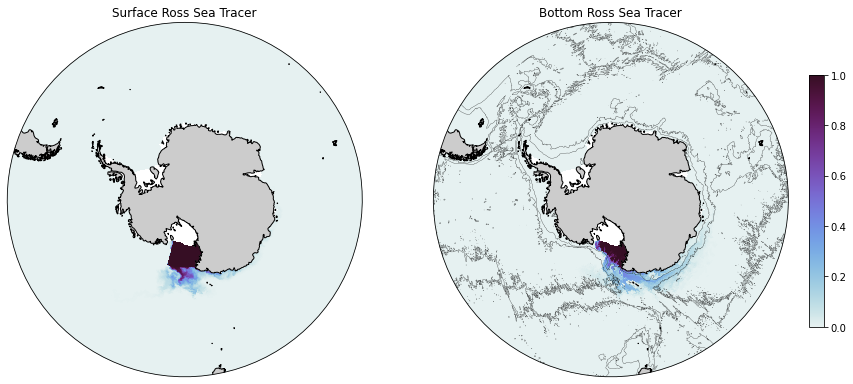

In [21]:
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(14, 7))
ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = surface_ross.plot(add_colorbar=False,vmin=0,vmax=1,cmap=cm.cm.dense,transform=ccrs.PlateCarree())
ax.set_title('Surface Ross Sea Tracer')

ax = plt.subplot(1, 2, 2, projection=projection)
ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')
ax.set_boundary(circle, transform=ax.transAxes)

p2 = bottom_ross.plot(add_colorbar=False,vmin=0,vmax=1,cmap=cm.cm.dense,transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000, 3500],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
ax.set_title('Bottom Ross Sea Tracer')

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p2,cax=ax_cb, orientation='vertical',shrink=0.5)

plt.savefig('TracerConcentration.png')